In [1]:
# import required libraries
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import string

In [2]:
# download punctuation and stopwords from nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
import os
# Find the latest version of spark 3.2  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.2.3'
# spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [1,039 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:1

# Transform the data

In [5]:
# load tweets_df and view
# tweets_df = pd.read_csv("Resources/Tweets.csv")



from pyspark import SparkFiles
# url ="https://tweet-2022.s3.amazonaws.com/Tweets.csv"
# spark.sparkContext.addFile(url)
# spark_tweets_df = spark.read.csv(SparkFiles.get("Tweets.csv"), sep=",", header=True)
# tweets_df = spark.read.csv(SparkFiles.get("Tweets.csv"), sep=",", header=True)


tweets_df = pd.read_csv("/content/Tweets.csv")
# tweets_df=spark_tweets_df.toPandas()
tweets_df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
16438,cfab7a12da,"Sounds lovely, hope you have a great day","Sounds lovely,",positive
16439,3e90b21788,you`re welcome,you`re welcome,neutral
16440,8a1f99c790,_1988 cool i wish i could av gone 2 da 1 he di...,but i couldnt,negative
16441,fea9c59435,i miss justin timberlake`s voice. i want him t...,i miss,negative


In [6]:
# get dataframe ready for processing

# make sure the tweets in column "text" are strings
tweets_df['text'] = tweets_df['text'].astype('str')

# delete the unneccessary columns
tweets_df = tweets_df.drop(columns=["textID", "selected_text"])

In [7]:
def process_tweets(tweet):
    # make the text all lowercase
    tweet = tweet.lower()
    
    # remove punctuation
    tweet = "".join(char for char in tweet if char not in string.punctuation)
    
    # tokenize the tweet for url clean
    tokenize_tweet_url = word_tokenize(tweet)
    
    # remove urls
    tokenize_tweet_url = " ".join([i for i in tokenize_tweet_url if 'http' not in i])
    
    # tokenize the tweet
    tokenize_tweets = word_tokenize(tokenize_tweet_url)
    
    # remove stopwords
    stopword = stopwords.words("english")
    tweet_wo_stop = [word for word in tokenize_tweets if word not in stopword]
    
    # lemmatization
    lemm = WordNetLemmatizer()
    lemmed = [lemm.lemmatize(word) for word in tweet_wo_stop]
    
    # put string together
    final_tweet = " ".join(lemmed)
    
    return final_tweet

In [8]:
# process tweets using above function
tweets_df['text'] = tweets_df['text'].apply(lambda x: process_tweets(x))
tweets_df = tweets_df.dropna()

# view updated dataframe
tweets_df.head()

,text,sentiment
0,id responded going,neutral
1,sooo sad miss san diego,negative
2,bos bullying,negative
3,interview leave alone,negative
4,son couldnt put release already bought,negative


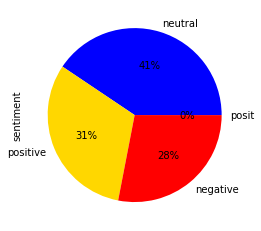

In [9]:
# visualize distribution
tweets_df.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'gold', 'red'])

In [10]:
# transform the sentiment column into numbers
dict_sentiment = {'positive': 1, 'neutral': 0, 'negative': -1}
tweets_df['sentiment'] = tweets_df['sentiment'].apply(lambda x: dict_sentiment.get(x))

# view updated dataframe
tweets_df.head()

,text,sentiment
0,id responded going,0.0
1,sooo sad miss san diego,-1.0
2,bos bullying,-1.0
3,interview leave alone,-1.0
4,son couldnt put release already bought,-1.0


In [ ]:
# create a separate data frame without neutral tweets
tweets_no_neut = tweets_df[tweets_df["sentiment"] != 0]

In [ ]:
# Create the X and y data 
def create_train_test_data (tweets_df, train_size):
    
    # assign X and y to the input and target columns
    X = tweets_df['text']
    y = tweets_df['sentiment']

    # split the data into testing data and training data
    if train_size == 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)

    # transform the data into tfidf vectors
    # fit the tfidf vectorizer on the training data to avoid bias
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, y_train, y_test

In [ ]:
# create the model
def create_model(tweets_df, attempt_num, model, train_size):
    # Get the train and test data
    
    X_train_tfidf, X_test_tfidf, y_train, y_test = create_train_test_data (tweets_df, train_size)

    # create a logistic regression model and fit it to the training data
    
    model.fit(X_train_tfidf, y_train)
    evaluate(model, X_train_tfidf, y_train, X_test_tfidf, y_test, attempt_num)

In [ ]:
# evaluate the model
def evaluate(model, X_train_tfidf, y_train, X_test_tfidf, y_test, attempt_num):
    
    # look at the scores for the testing and training data
    print(f"Attempt {attempt_num} ----------------------------------------")
    print(f"Training Data Score: {model.score(X_train_tfidf, y_train)}")
    print(f"Testing Data Score: {model.score(X_test_tfidf, y_test)} \n")

    # find metrics for testing data
    print(confusion_matrix(y_test.values, model.predict(X_test_tfidf)))
    print(classification_report(y_test.values, model.predict(X_test_tfidf)))

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
create_model(tweets_df, 1, model, 0)
create_model(tweets_no_neut, 2, model, 0)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Attempt 1 ----------------------------------------
Training Data Score: 0.8200873362445414
Testing Data Score: 0.6962596419735119 

[[1179  675  112]
 [ 328 2117  343]
 [  74  555 1488]]
              precision    recall  f1-score   support

          -1       0.75      0.60      0.66      1966
           0       0.63      0.76      0.69      2788
           1       0.77      0.70      0.73      2117

    accuracy                           0.70      6871
   macro avg       0.71      0.69      0.70      6871
weighted avg       0.71      0.70      0.70      6871

Attempt 2 ----------------------------------------
Training Data Score: 0.929351368970013
Testing Data Score: 0.8724028354925446 

[[1674  247]
 [ 275 1895]]
              precision    recall  f1-score   support

          -1       0.86      0.87      0.87      1921
           1       0.88      0.87      0.88      2170

    accuracy                           0.87      4091
   macro avg       0.87      0.87      0.87      4091
we

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

twitter_classi = RandomForestClassifier(n_estimators=300, random_state=0)
create_model(tweets_df, 1, twitter_classi, train_size=.8)
create_model(tweets_no_neut, 2, twitter_classi, train_size=.8)

Attempt 1 ----------------------------------------
Training Data Score: 0.9975891557496361
Testing Data Score: 0.6941968346370748 

[[ 902  500  114]
 [ 272 1669  332]
 [  69  394 1245]]
              precision    recall  f1-score   support

          -1       0.73      0.59      0.65      1516
           0       0.65      0.73      0.69      2273
           1       0.74      0.73      0.73      1708

    accuracy                           0.69      5497
   macro avg       0.70      0.69      0.69      5497
weighted avg       0.70      0.69      0.69      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.9995416348357525
Testing Data Score: 0.8643446379468378 

[[1375  221]
 [ 223 1454]]
              precision    recall  f1-score   support

          -1       0.86      0.86      0.86      1596
           1       0.87      0.87      0.87      1677

    accuracy                           0.86      3273
   macro avg       0.86      0.86      0.86      3273
w

## Extra Trees Classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

twitter_ex = ExtraTreesClassifier(random_state=1)
create_model(tweets_df, 1, twitter_ex, train_size=.8)
create_model(tweets_no_neut, 2, twitter_ex, train_size=.8)

Attempt 1 ----------------------------------------
Training Data Score: 0.9975891557496361
Testing Data Score: 0.6994724395124613 

[[ 936  475  117]
 [ 320 1565  330]
 [  63  347 1344]]
              precision    recall  f1-score   support

          -1       0.71      0.61      0.66      1528
           0       0.66      0.71      0.68      2215
           1       0.75      0.77      0.76      1754

    accuracy                           0.70      5497
   macro avg       0.71      0.70      0.70      5497
weighted avg       0.70      0.70      0.70      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.9995416348357525
Testing Data Score: 0.8579285059578369 

[[1346  204]
 [ 261 1462]]
              precision    recall  f1-score   support

          -1       0.84      0.87      0.85      1550
           1       0.88      0.85      0.86      1723

    accuracy                           0.86      3273
   macro avg       0.86      0.86      0.86      3273
w

## Ada Boost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
twitter_ada = AdaBoostClassifier(random_state=1)
create_model(tweets_df, 1, twitter_ada, train_size=.8)
create_model(tweets_no_neut, 2, twitter_ada, train_size=.8)

Attempt 1 ----------------------------------------
Training Data Score: 0.6543850072780204
Testing Data Score: 0.665999636165181 

[[ 641  782  110]
 [ 185 1855  252]
 [  44  463 1165]]
              precision    recall  f1-score   support

          -1       0.74      0.42      0.53      1533
           0       0.60      0.81      0.69      2292
           1       0.76      0.70      0.73      1672

    accuracy                           0.67      5497
   macro avg       0.70      0.64      0.65      5497
weighted avg       0.69      0.67      0.66      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.8083269671504966
Testing Data Score: 0.8041552092881149 

[[1418  145]
 [ 496 1214]]
              precision    recall  f1-score   support

          -1       0.74      0.91      0.82      1563
           1       0.89      0.71      0.79      1710

    accuracy                           0.80      3273
   macro avg       0.82      0.81      0.80      3273
we

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
create_model(tweets_df,1,mnb,train_size=0.8)
create_model(tweets_no_neut,2,mnb,train_size=0.8)

Attempt 1 ----------------------------------------
Training Data Score: 0.7995360262008734
Testing Data Score: 0.6243405493905767 

[[ 636  839   70]
 [ 159 1853  270]
 [  18  709  943]]
              precision    recall  f1-score   support

          -1       0.78      0.41      0.54      1545
           0       0.54      0.81      0.65      2282
           1       0.73      0.56      0.64      1670

    accuracy                           0.62      5497
   macro avg       0.69      0.60      0.61      5497
weighted avg       0.67      0.62      0.62      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.9420932009167303
Testing Data Score: 0.846012832263978 

[[1273  305]
 [ 199 1496]]
              precision    recall  f1-score   support

          -1       0.86      0.81      0.83      1578
           1       0.83      0.88      0.86      1695

    accuracy                           0.85      3273
   macro avg       0.85      0.84      0.85      3273
we

# Naive Bayes using PySpark

In [11]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("NaiveBayes").getOrCreate()
# url ="https://tweet-2022.s3.amazonaws.com/Tweets.csv"
# spark.sparkContext.addFile(url)
# spark_tweets_df = spark.read.csv(SparkFiles.get("Tweets.csv"), sep=",", header=True)
# tweets_df = spark.read.csv(SparkFiles.get("Tweets.csv"), sep=",", header=True)


nb_tweets_df = pd.read_csv("/content/Tweets.csv")
# tweets_df=spark_tweets_df.toPandas()
nb_tweets_df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [ ]:
def nb_process_tweets(tweet):
    # make the text all lowercase
    tweet = tweet.lower()
    
    # remove punctuation
    tweet = "".join(char for char in tweet if char not in string.punctuation)
  
    # remove urls
    tweet_wo_stop = "".join([i for i in tweet if 'http' not in i])
    
    
    # lemmatization
    lemm = WordNetLemmatizer()
    lemmed = [lemm.lemmatize(word) for word in tweet_wo_stop]
    
    # put string together
    final_tweet = "".join(lemmed)
    
    return final_tweet
nb_tweets_df['text'] = nb_tweets_df['text'].astype('str')

# delete the unneccessary columns
nb_tweets_df = nb_tweets_df.drop(columns=["textID", "selected_text"])
nb_tweets_df=nb_tweets_df.rename(columns={'sentiment':'class'})
nb_tweets_df=nb_tweets_df[['class','text']]
nb_tweets_df['text'] = nb_tweets_df['text'].apply(lambda x: nb_process_tweets(x))


nb_opt=nb_tweets_df.loc[nb_tweets_df['class']!="neutral"]

In [ ]:
pip install quinn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes

In [28]:
def create_nb(tweets_df,attempt_num,model,train_size):
  from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
# Create all the features to the data set
  pos_neg_to_num = StringIndexer(inputCol='class',outputCol='label')
  tokenizer = Tokenizer(inputCol="text", outputCol="token_text")
  stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
  hashingTF = HashingTF(inputCol="stop_tokens", outputCol='hash_token')
  idf = IDF(inputCol='hash_token', outputCol='idf_token')
  from pyspark.ml.feature import VectorAssembler
  from pyspark.ml.linalg import Vector

  # Create feature vectors
  clean_up = VectorAssembler(inputCols=['idf_token', 'length'], outputCol='features')
  from pyspark.ml import Pipeline
  data_prep_pipeline = Pipeline(stages=[pos_neg_to_num, tokenizer, stopremove, hashingTF, idf, clean_up])
  from pyspark.sql import SQLContext
  sc = SparkSession.builder.getOrCreate()
  sqlContext = SQLContext(sc)
  spark_tweets = sqlContext.createDataFrame(tweets_df)



  import quinn
  trimmed=spark_tweets.withColumn('description',quinn.single_space(spark_tweets['text']))
  trimmed=trimmed.select('class','description')
  trimmed=trimmed.withColumnRenamed('description','text')
  trimmed=trimmed.toPandas()
  trimmed['length']=""
  for index,row in trimmed.iterrows():
    nb_tweet_length=len(row['text'])
    trimmed.loc[index,'length']=nb_tweet_length
  trimmed_spark=sqlContext.createDataFrame(trimmed)
  cleaner = data_prep_pipeline.fit(trimmed_spark)
  cleaned = cleaner.transform(trimmed_spark)

  # cleaner = data_prep_pipeline.fit(spark_tweets)
  # cleaned = cleaner.transform(spark_tweets)
  
  # Break data down into a training set and a testing set
  # training, testing = cleaned.randomSplit([0.7, 0.3])
  training, testing = cleaned.randomSplit([train_size, 1-train_size])
  predictor = nb.fit(training)
  
  test_results = predictor.transform(testing)
  acc_eval = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction")
  acc = acc_eval.evaluate(test_results)
  predictionAndTarget = test_results.select("label", "prediction")

  # Get metrics
  # train_acc=acc_eval(predictor.transform(testing).select('label','prediction'))
  acc = acc_eval.evaluate(predictionAndTarget, {acc_eval.metricName: "accuracy"})
  f1 = acc_eval.evaluate(predictionAndTarget, {acc_eval.metricName: "f1"})
  weightedPrecision = acc_eval.evaluate(predictionAndTarget, {acc_eval.metricName: "weightedPrecision"})
  weightedRecall = acc_eval.evaluate(predictionAndTarget, {acc_eval.metricName: "weightedRecall"})
  auc = acc_eval.evaluate(predictionAndTarget)
  # print(f"Training Accuracy of model: {train_acc}")
  print(f"Testing Accuracy of model: {acc}")
  print(f"Precision of model: {weightedPrecision}")
  print(f"Recall of model:{weightedRecall}")

In [27]:
nb = NaiveBayes(labelCol="label", featuresCol="features", modelType="multinomial")
create_nb(nb_tweets_df,1,nb,.8)
create_nb(nb_opt,2,nb,.8)


TypeError: ignored